In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import warnings

<ipython-input-1-7469273fca13>:20: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [3]:
# load clr, uses 5kb, any res can be used
clr = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_5000_raw.cool")


In [6]:
#### chrom file ####
ce10=bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')
print(ce10)
ce10=bioframe.parse_regions(ce10)

  chrom  start       end
0     I      0  15072423
1    II      0  15279345
2   III      0  13783700
3    IV      0  17493793
4     V      0  20924149
5     X      0  17718866


In [2]:
def scaling_agg(input_clr,input_regions):
    cvd = cooltools.expected.diagsum(
        clr=input_clr,
        regions=input_regions,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * input_clr.binsize
    lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * input_clr.binsize
    x = np.array(lb_slopes_agg['s_bp'])
    y = np.array(lb_slopes_agg['slope'])
    loop_size = x[argrelextrema(y, np.greater)]
    return(lb_cvd_agg,lb_slopes_agg,loop_size)

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [10]:

# X and autosomes split
agg_AX = []
a = scaling_agg(clr,ce10.iloc[0:4].reset_index(drop=True)) # autosomes
x = scaling_agg(clr,ce10.iloc[[5]].reset_index(drop=True)) # X chromosome
agg_AX.append(a)
agg_AX.append(x)


# all chromosomes split
agg_perchr = []
for i in range(ce10.shape[0]): # loop through each chr
    x = scaling_agg(clr,ce10.iloc[[i]].reset_index(drop=True))
    agg_perchr.append(x)



In [15]:
## data structure of the output

print(len(agg_AX)) # layer1: length of 2 - autosome and X-chromosome
print(len(agg_AX[0])) # layer2: length of 3 - Ps, logPs, local max of logPs (aka loop size)

print(len(agg_perchr)) # layer1: length of 6 - 6 chromosomes in c elegans
print(len(agg_perchr[0])) # layer2: length of 3 - Ps, logPs, local max of logPs (aka loop size)


2
3
6
3


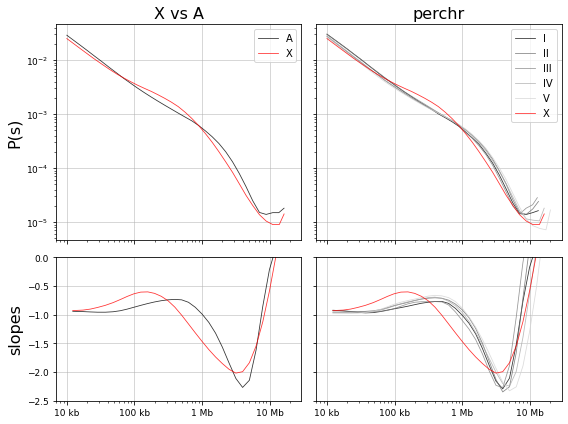

In [25]:
########################## Ps, slopes ############################
f, axs = plt.subplots(
    figsize=(8,6),
    ncols=2,
    nrows=2,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios':[6,4]}
)

# global params and labels #
Alpha = 0.8
lineWidth = 0.8
bigFont = 16
smallFont = 9
slopes_minmax = [-2.5,0]
subtitles = ['X vs A','perchr']

## first column, plot X v A
ax1 = axs[0,0]
ax2 = axs[1,0]
labels = ['A','X']
colors = ['black','red']
dat = agg_AX
for i in range(len(dat)): # loop through the first layer, ie autosome and X-chromosome
    ax1.loglog( # this is Ps
        dat[i][0]['s_bp'],
        dat[i][0]['balanced.avg'],
        label=labels[i],
        color=colors[i],linewidth=lineWidth,alpha=Alpha)
    ax2.semilogx( # this is log-derivative of Ps
        dat[i][1]['s_bp'],
        dat[i][1]['slope'],
        label=labels[i],
        color=colors[i],linewidth=lineWidth,alpha=Alpha)

## second column, plot per chr
ax1 = axs[0,1]
ax2 = axs[1,1]
labels = ['I','II','III','IV','V','X']
colors = ['black','dimgrey','grey','darkgrey','lightgrey','red']
dat = agg_perchr
## below is the same as above
for i in range(len(dat)): # loop through the first layer, ie autosome and X-chromosome
    ax1.loglog( # this is Ps
        dat[i][0]['s_bp'],
        dat[i][0]['balanced.avg'],
        label=labels[i],
        color=colors[i],linewidth=lineWidth,alpha=Alpha)
    ax2.semilogx( # this is log-derivative of Ps
        dat[i][1]['s_bp'],
        dat[i][1]['slope'],
        label=labels[i],
        color=colors[i],linewidth=lineWidth,alpha=Alpha)
## above is the same as above


#### labeling/asthetics
for i in range(2): #loop through each colmn
    axs[0,i].set_title(subtitles[i],size=bigFont)
    axs[0,i].grid(lw=0.5) # add some grids on graph
    axs[1,i].grid(lw=0.5)
    format_ticks(axs[1,i],y=False,rotate=False) # format ticks only for x-axis for second row
    axs[0,i].tick_params(labelsize=smallFont) # axis tick font size
    axs[1,i].tick_params(labelsize=smallFont)
    axs[1,i].set_ylim(slopes_minmax) # min max values for slopes
    axs[0,i].legend() #add legend to plot

# ylabel
axs[0,0].set_ylabel('P(s)',size=bigFont)
axs[1,0].set_ylabel('slopes',size=bigFont)


plt.tight_layout()

In [26]:
f.savefig('/scratch/kimj50/test.pdf',dpi=800,bbox_inches='tight')